- Wind energy production/amount is a function of _wind speed_ and its _direction_.
 - forecast amount is sold to the grid operator
 - the grid operator fines if there's shortfall from forecast
 - excess is wasted
- Grid operator **(buys , 10 euro cents/kWh)**, enforces fines if there's a shortfall by the energy producer
- Spot market price for energy **(sells, 20 euro cents/kWh)**
- In case if we do not have anough cash to buy from the spot market, we pay a fine for the amount we failed to deliver **(penalty, 100 euro cents/kWh)**

__Objective__
- Our goal is to get a **T+18 hour energy forecast , every hour for entire Ile-de-France region**. Our objective, as a trader, is to maximize profits for our client using our energy production forecast and the given trading algorithm (this alg-m is fixed for simplicity).


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os, pandas as pd, numpy as np
import datetime
from src import datautils

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (15,6)
%matplotlib inline

In [ ]:
# !ln -s ../src/ .

## Trade:
1. Produce a forecast
    - Excess is wasted (i.e. 0cents/kWh)
    - Shortfall is covered by trader (we need to buy this amount from spot market, _if we have cash in hand_ ):
        - buy 20cents/kWh
    - If there's no money to buy:
        - If _cash in hand_ is lower than required to purchase the shortfall amount
        - We are fined by grid 100cents/kWh
        - Recorded as a negative value (debt), and it's cumulative.
1. Starting budget 10,000,000 cents
1. Need to return 10,000,000 cents at the end of the evaluation period.
1. The remainder is our client's profits. Our objective is to maximise this profit.

## Datasets and Sources
Datasets:
1. Wind Energy Production \[src : Réseau de transport d'électricité [(RTE)](https://www.rte-france.com/), the French electricity transmission system operator\]
    - **We average and standardise to a time base of 1 hour** a near-realtime wind energy data from RTE's online database.
    - The dataset is called `energy-ile-de-france` (contains the consolidated energy wind production for the Ile-de-France region surrounding Paris)
2. Wind Forecasts \[src : [Terra Weather](http://www.terra-weather.com)\]
    - Provided are _wind forecasts for 8 locations_ of major wind farms in the Ile-de-France region.



### Wind Energy Production Data
- We use data __from 01 Jan 2017 to the present__. (download these)
- Real-time data are in Paris time.
- [`https://www.rte-france.com/en/eco2mix/eco2mix-telechargement-en`](https://www.rte-france.com/en/eco2mix/eco2mix-telechargement-en)
- The energy production (power) values are in __MW__ units (we need to convert them to kWh before trading! *i.e. get mean power over hour to get energy*).

---
Notes on Wind Energy Datasets:
1. **AI4Impact `energy-ile-de-france` Dataset**<br>
In autocaffe, the dataset is called `energy-ile-de-france`, and contains *standardised 1 hourly values* (UTC, in kWh).<br>
AI4Impact link for all years including latest readings (**all in UTC and kWh**):
    - 1/1/2017-*now*: `https://ai4impact.org/P003/historical/energy-ile-de-france.csv`
    - **to download it** use `datautils.download_energy_latest()` (from `/src/datautils.py`)
    - **to read** use `datautils.read_ai4impact_energy(...)`
    - AI4Impact is delayed compared to the raw RTE data.
1. **Raw Datasets from RTE**<br>
Following are for downloading regional energy production _raw data for Ile-de-France_ :
    - **for downloading** RTE data use `datautils.download_raw_from_RTE()` (in `/src/datautils.py`), for available urls see
    `datautils.wind_energy_urls`.
    - **to read** in kWh use `datautils.read_RTE_as_kwh(...,convert2UTC=True)` (in `/src/datautils.py`, set convert2UTC=True for real-time data).
    - For 2019_May2020 data ("Consolide" data) YOU WILL NEED TO REMOVE EXTRA COLUMNS (each row has different #col-s), before reading with pandas.
        - The current fixed version of this dataset (data for 01/01/2019-31/05/2020) is `./datasets/eCO2mix_RTE_Ile-de-France_En-cours-Consolide_FIXED_ERRCOLS.xls`
    - Regarding different datasets from RTE website, the "Current consolidated data" and "Current real-time data" could change which dates they contain depending on when you are downloading them. (*see disclaimer from RTE website below*):<br>
    >During the course of the following month, the indicators are consolidated to include available metering data. During the first six months of the following year, the indicators are finalized with the latest metering data and become definitive. 

---
**Total Nominal Power Outputs** of all wind farms in the Ile-de-France region (based on RTE website data):
- 01/01/2017 - 01/06/2017 : 43MW
- 01/06/2017 - 01/12/2017 : 55MW
- 01/12/2017 - 01/09/2019 : 70MW
- 01/09/2019 - now : 89MW (~89.8MW)<br>
The Difference network should be able to handle the changes above (nominal power— max. possible output, changes in time as newer and larger wind farms are built)


- **Download latest readings** (includes 1/1/2017-now)

#### Downloading and Reading AI4Impact Wind Energy Data

UTC time now: 2020-07-14 08:21:28

Downloaded from:
`https://ai4impact.org/P003/historical/energy-ile-de-france.csv`
saved to:
datasets/energy-ile-de-france.csv
                     Energy(kWh)
Datetime                        
2020-07-14 03:00:00       6750.0
2020-07-14 04:00:00       6000.0
2020-07-14 05:00:00       5000.0
2020-07-14 06:00:00       5500.0
2020-07-14 07:00:00       5500.0


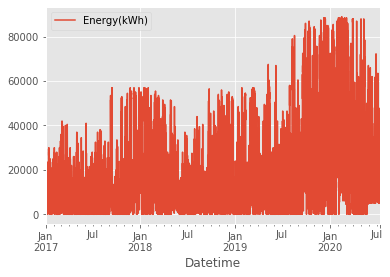

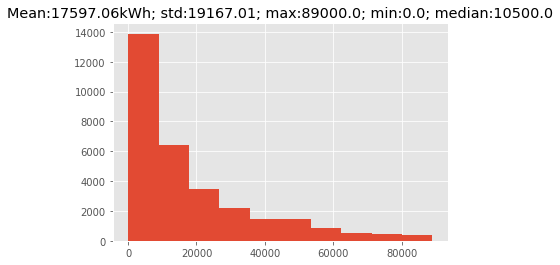

In [ ]:
t = datetime.datetime.utcnow()
print('UTC time now: {}-{:02d}-{:02d} {:02d}:{:02d}:{:02d}\n'.format(t.year,t.month,t.day, t.hour,t.minute,t.second))
datautils.download_energy_latest()
df = datautils.read_ai4impact_energy('datasets/energy-ile-de-france.csv')
print(df.tail())
df.plot()
plt.show()

plt.hist(df.values)
x= df.values
plt.title(f'Mean:{x.mean():.2f}kWh; std:{x.std():.2f}; max:{x.max()}; min:{x.min()}; median:{np.median(x)}');
plt.show()

#### Downloading and Reading Raw RTE (+ real-time data from RTE)

Downloading
"eCO2mix_RTE_Ile-de-France_En-cours-TR.zip" from
`https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip`

Extracting: datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip
eCO2mix_RTE_Ile-de-France_En-cours-TR.xls --> as "datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.xls"
- - - - - 
File Name                                             Modified             Size
eCO2mix_RTE_Ile-de-France_En-cours-TR.xls      2020-07-14 09:31:06       956955
- - - - - 
Deleting
datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip

UTC time now: 2020-07-14 08:21:37

Latest timestamp for wind energy:
2020-07-14 07:00:00
                     Energy(kWh)
Datetime                        
2020-07-14 03:00:00       6750.0
2020-07-14 04:00:00       6000.0
2020-07-14 05:00:00       5000.0
2020-07-14 06:00:00       5500.0
2020-07-14 07:00:00       5500.0


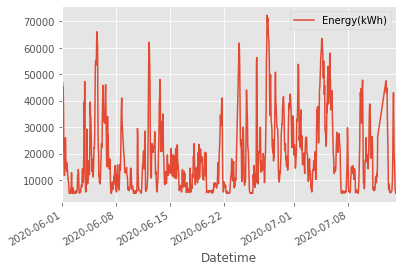

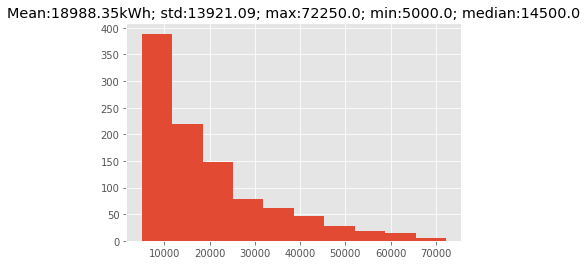

In [ ]:
RTE_data_name = 'real_time'
RTE_file_path = datautils.download_raw_from_RTE(RTE_data_name,return_filelist=True)

# RTE_file_names = {"2017":"eCO2mix_RTE_Ile-de-France_Annuel-Definitif_2017.xls",
#               "2018":"eCO2mix_RTE_Ile-de-France_Annuel-Definitif_2018.xls",
#               "2019_May2020":"eCO2mix_RTE_Ile-de-France_En-cours-Consolide_FIXED_ERRCOLS.xls",
#               "real_time":"eCO2mix_RTE_Ile-de-France_En-cours-TR.xls"}
# file location: os.path.join(data_path,RTE_file_name0)


df=datautils.read_RTE_as_kwh(RTE_file_path[0],convert2UTC=True)
t = datetime.datetime.utcnow()
print('UTC time now: {}-{:02d}-{:02d} {:02d}:{:02d}:{:02d}\n'.format(t.year,t.month,t.day, t.hour,t.minute,t.second))
print(f'Latest timestamp for wind energy:\n{df.index[-1]}')
print(df.tail())
df.plot()
plt.show()

plt.hist(df.values)
x= df.values
plt.title(f'Mean:{x.mean():.2f}kWh; std:{x.std():.2f}; max:{x.max()}; min:{x.min()}; median:{np.median(x)}');
plt.show()

In [ ]:
# from datetime import datetime
# # unix time in ms to human-readable time format:
# datetime.utcfromtimestamp(1483232400000//1000).strftime('%Y-%m-%d %H:%M:%S')

### Wind Forecasts Data
Wind forecasts data for locations of major 8 wind farms in Ile-de-France are provided by [Terra Weather](http://www.terra-weather.com).
- Available data : __from 01 Jan 2017 to the present__ 
- UTC time zone
- Wind data come from _2 models_ , thus there are `2x8=16` forecasts in total.
- 2 var-s: `[` wind speed (m/s), direction (deg-N)`]`
    - wind dir-s are "from", e.g. 45 deg means wind is blowing _from_ the NE.
- **Real-time forecasts** are updated 4x daily (*every 6 hours*):
    - **from latest-update-to-(+10 days, same time)**
    - 2 models can have different update frequencies, and forecast lengths
    - Probably need to interpolate, fuse and take mean of the forecasts
- Historical forecats or "analysis" winds: our best guess from observations.
    - from 1/1/2017-
- Need to **interpolate** (linear interpolation) to hourly basis _each forecast file_.

In [ ]:
# wind farm locations
print(datautils.locations)
# angerville-2 is "Les Pointes" wind farm

['guitrancourt', 'lieusaint', 'lvs-pussay', 'parc-du-gatinais', 'arville', 'boissy-la-riviere', 'angerville-1', 'angerville-2']


- **Download Wind Forecasts** (Need to Download ~6-hourly):
    - to download **both latest and historical** use `datautils.download_forecasts_all()`
    - to download **only latest** use `datautils.download_forecasts_latest()`

In [ ]:
print(f'Downloading all forecats for \n{datautils.locations}')
datautils.download_forecasts_all()
# # to download just the latest forecasts use: `download_forecasts_latest()`
# datautils.download_forecasts_latest()

['guitrancourt', 'lieusaint', 'lvs-pussay', 'parc-du-gatinais', 'arville', 'boissy-la-riviere', 'angerville-1', 'angerville-2']
Latest wind forecasts:
Downloaded latest forecasts from
`https://ai4impact.org/P003/`
saved to
datasets

Historical wind forecasts:
Downloaded historical forecasts from
`https://ai4impact.org/P003/historical/`
saved to
datasets



- to print **names of the wind farm locations** use `datautils.locations` (list of names as `str`'s)
- for a location `[name]`:
    - **model 1 forecasts**:
        - **latest**--> `datasets/model1/[name].csv`
        - **hist-l**--> `datasets/historical1/[name].csv`
    - **model 2 forecasts** (names end with `*-b.csv`):
        - **latest**--> `datasets/model2/[name]-b.csv`
        - **hist-l**--> `datasets/historical2/[name]-b.csv`

In [ ]:
data_path = os.path.relpath('datasets/model1/')
file_name = datautils.locations[0]+'.csv'

print(f'Loading\n{os.path.join(data_path,file_name)}')
df = datautils.read_forecast(os.path.join(data_path,file_name))

# df[df.index>=pd.to_datetime('10 Jul 2020')]
df

Loading
datasets/model1/guitrancourt.csv


,Speed(m/s),Direction (deg N)
Datetime,,
2020-07-14 00:00:00,1.86,340
2020-07-14 03:00:00,1.58,303
2020-07-14 06:00:00,1.69,281
2020-07-14 09:00:00,0.89,222
2020-07-14 12:00:00,3.87,247
...,...,...
2020-07-23 12:00:00,2.23,349
2020-07-23 15:00:00,2.79,360
2020-07-23 18:00:00,5.18,14


In [ ]:
data_path = os.path.relpath('datasets/model2/')
file_name = datautils.locations[0]+'-b.csv'

print(f'Loading\n{os.path.join(data_path,file_name)}')
df = datautils.read_forecast(os.path.join(data_path,file_name))

# df[df.index>=pd.to_datetime('10 Jul 2020')]
df

Loading
datasets/model2/guitrancourt-b.csv


,Speed(m/s),Direction (deg N)
Datetime,,
2020-07-13 18:00:00,3.78,349
2020-07-13 21:00:00,4.08,352
2020-07-14 00:00:00,2.23,337
2020-07-14 03:00:00,1.44,290
2020-07-14 06:00:00,1.79,265
2020-07-14 09:00:00,2.35,258
2020-07-14 12:00:00,2.82,265
2020-07-14 15:00:00,4.14,296
2020-07-14 18:00:00,3.74,321


- Joining multiple forecasts

In [ ]:
name_k = 0
dfs = []
models = ['model1','model2']
for farm in datautils.locations:
    for m in models:
        file_end = '.csv' if m==models[0] else '-b.csv'
        m_name = '_m1_' if m==models[0] else '_m2_'
        df = datautils.read_forecast( os.path.join( './datasets/', m, farm + file_end))
        df.rename(columns={'Speed(m/s)':farm+m_name+'speed','Direction (deg N)':farm+m_name+'dir'},
                  inplace=True)
        dfs.append(df)
# concatenate along axis 1 using datetime as reference
dfs = pd.concat(dfs,axis=1)

# method 1: use nearest neighbour (+ reindex for 1H freq)
# reindex part is not needed when joining with RTE power data with freq=1H
dfs = dfs.reindex(pd.date_range(dfs.index[0],dfs.index[-1],freq='H')).interpolate(method='nearest')

# method 2: use linear interpolation (for 1H freq)
# dfs = dfs.reindex(pd.date_range(dfs.index[0],dfs.index[-1],freq='H')).interpolate(method='linear')

# method 1b and 2b: use the methods above to get 1H freq, and then average for two models:
# ("speed1"*[cos(dir1), sin(dir1)] + "speed2"*[cos(dir2), sin(dir2)] )/2
# averaging vectors: need to use vector addition and then divide by 2.

## Trader

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from trader import trader_simulation
# These are defaults for  trader.trader_simulation()
INITIAL_CASH = 10000000 # euro cents, starting capital
SALE_PRICE = 10 # euro cents/kWh
SPOT_PRICE = 20 # euro cents/kWh
PENALTY_PRICE = 100 # euro cents/kWh

In [ ]:
trading_hours = df['Eolien'][np.logical_not(df['Eolien'].isna())].index
print(f'Trading hours (total):{len(trading_hours)}, [start:{str(trading_hours[0])} ---> end:{str(trading_hours[-1])}]')
print(f'dT (frequency):{str(trading_hours[1]-trading_hours[0])}')

Trading hours (total):24816, [start:2019-01-01 00:00:00 ---> end:2020-05-31 23:30:00]
dT (frequency):0 days 00:30:00


Random trader, using Exponential distribution

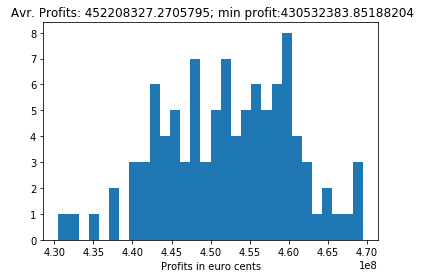

In [ ]:
# real values
Y_targ = df['Eolien'][np.logical_not(df['Eolien'].isna())].values*1000
trading_hours = df['Eolien'][np.logical_not(df['Eolien'].isna())].index

profits = []
for k in range(100):
    # here I set a limit 50000 to our random prediction
    Y_pred = np.minimum(17000,np.random.exponential(
        scale=5000,size=(len(trading_hours),))) # random predictions in kWh scale [0...80000]
    profits.append(trader_simulation(trading_hours,Y_pred,Y_targ))
plt.hist(profits,bins=30)
plt.xlabel('Profits in euro cents')
plt.title(f' Avr. Profits: {(np.mean(profits))}; min profit:{(np.min(profits))}');

Random Uniform Distribution Trader:

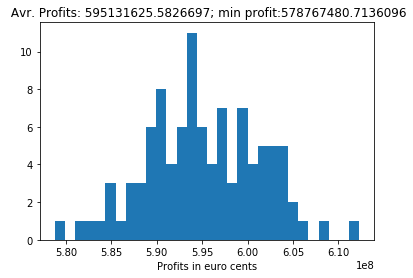

In [ ]:
# real values
Y_targ = df['Eolien'][np.logical_not(df['Eolien'].isna())].values*1000
trading_hours = df['Eolien'][np.logical_not(df['Eolien'].isna())].index

profits = []
for k in range(100):
    # here I set a limit 50000 to our random prediction
    Y_pred = 12000*np.random.rand(len(trading_hours)) # random predictions in kWh scale [0...80000]
    profits.append(trader_simulation(trading_hours,Y_pred,Y_targ))
plt.hist(profits,bins=30)
plt.xlabel('Profits in euro cents')
plt.title(f' Avr. Profits: {(np.mean(profits))}; min profit:{(np.min(profits))}');

Constant trader, predictions are constant

2019-01-01 00:00:00-> Act.Prod/Pred.:1000.0 /8000.0 (wasted:0c); Short./Avail.:7000.0 /500500.0; Penalty:0; Cash:9870000
2019-01-01 00:30:00-> Act.Prod/Pred.:1000.0 /8000.0 (wasted:0c); Short./Avail.:7000.0 /494000.0; Penalty:0; Cash:9740000
2019-01-01 01:00:00-> Act.Prod/Pred.:1000.0 /8000.0 (wasted:0c); Short./Avail.:7000.0 /487500.0; Penalty:0; Cash:9610000
2019-01-01 01:30:00-> Act.Prod/Pred.:2000.0 /8000.0 (wasted:0c); Short./Avail.:6000.0 /481500.0; Penalty:0; Cash:9510000
2019-01-01 02:00:00-> Act.Prod/Pred.:2000.0 /8000.0 (wasted:0c); Short./Avail.:6000.0 /476500.0; Penalty:0; Cash:9410000
2019-01-01 02:30:00-> Act.Prod/Pred.:2000.0 /8000.0 (wasted:0c); Short./Avail.:6000.0 /471500.0; Penalty:0; Cash:9310000
2019-01-01 03:00:00-> Act.Prod/Pred.:2000.0 /8000.0 (wasted:0c); Short./Avail.:6000.0 /466500.0; Penalty:0; Cash:9210000
2019-01-01 03:30:00-> Act.Prod/Pred.:5000.0 /8000.0 (wasted:0c); Short./Avail.:3000.0 /463000.0; Penalty:0; Cash:9200000
2019-01-01 04:00:00-> Act.Prod/P

2019-02-09 18:30:00-> Act.Prod/Pred.:27000.0 /8000.0 (wasted:190000c); Short./Avail.:0.0 /2149000.0; Penalty:0; Cash:42980000
2019-02-09 19:00:00-> Act.Prod/Pred.:38000.0 /8000.0 (wasted:300000c); Short./Avail.:0.0 /2153000.0; Penalty:0; Cash:43060000
2019-02-09 19:30:00-> Act.Prod/Pred.:36000.0 /8000.0 (wasted:280000c); Short./Avail.:0.0 /2157000.0; Penalty:0; Cash:43140000
2019-02-09 20:00:00-> Act.Prod/Pred.:35000.0 /8000.0 (wasted:270000c); Short./Avail.:0.0 /2161000.0; Penalty:0; Cash:43220000
2019-02-09 20:30:00-> Act.Prod/Pred.:33000.0 /8000.0 (wasted:250000c); Short./Avail.:0.0 /2165000.0; Penalty:0; Cash:43300000
2019-02-09 21:00:00-> Act.Prod/Pred.:34000.0 /8000.0 (wasted:260000c); Short./Avail.:0.0 /2169000.0; Penalty:0; Cash:43380000
2019-02-09 21:30:00-> Act.Prod/Pred.:41000.0 /8000.0 (wasted:330000c); Short./Avail.:0.0 /2173000.0; Penalty:0; Cash:43460000
2019-02-09 22:00:00-> Act.Prod/Pred.:45000.0 /8000.0 (wasted:370000c); Short./Avail.:0.0 /2177000.0; Penalty:0; Cash:4

2019-03-13 00:00:00-> Act.Prod/Pred.:54000.0 /8000.0 (wasted:460000c); Short./Avail.:0.0 /2971500.0; Penalty:0; Cash:59430000
2019-03-13 00:30:00-> Act.Prod/Pred.:51000.0 /8000.0 (wasted:430000c); Short./Avail.:0.0 /2975500.0; Penalty:0; Cash:59510000
2019-03-13 01:00:00-> Act.Prod/Pred.:49000.0 /8000.0 (wasted:410000c); Short./Avail.:0.0 /2979500.0; Penalty:0; Cash:59590000
2019-03-13 01:30:00-> Act.Prod/Pred.:52000.0 /8000.0 (wasted:440000c); Short./Avail.:0.0 /2983500.0; Penalty:0; Cash:59670000
2019-03-13 02:00:00-> Act.Prod/Pred.:51000.0 /8000.0 (wasted:430000c); Short./Avail.:0.0 /2987500.0; Penalty:0; Cash:59750000
2019-03-13 02:30:00-> Act.Prod/Pred.:52000.0 /8000.0 (wasted:440000c); Short./Avail.:0.0 /2991500.0; Penalty:0; Cash:59830000
2019-03-13 03:00:00-> Act.Prod/Pred.:49000.0 /8000.0 (wasted:410000c); Short./Avail.:0.0 /2995500.0; Penalty:0; Cash:59910000
2019-03-13 03:30:00-> Act.Prod/Pred.:46000.0 /8000.0 (wasted:380000c); Short./Avail.:0.0 /2999500.0; Penalty:0; Cash:5

2019-04-13 06:00:00-> Act.Prod/Pred.:21000.0 /8000.0 (wasted:130000c); Short./Avail.:0.0 /4969500.0; Penalty:0; Cash:99390000
2019-04-13 06:30:00-> Act.Prod/Pred.:20000.0 /8000.0 (wasted:120000c); Short./Avail.:0.0 /4973500.0; Penalty:0; Cash:99470000
2019-04-13 07:00:00-> Act.Prod/Pred.:20000.0 /8000.0 (wasted:120000c); Short./Avail.:0.0 /4977500.0; Penalty:0; Cash:99550000
2019-04-13 07:30:00-> Act.Prod/Pred.:20000.0 /8000.0 (wasted:120000c); Short./Avail.:0.0 /4981500.0; Penalty:0; Cash:99630000
2019-04-13 08:00:00-> Act.Prod/Pred.:19000.0 /8000.0 (wasted:110000c); Short./Avail.:0.0 /4985500.0; Penalty:0; Cash:99710000
2019-04-13 08:30:00-> Act.Prod/Pred.:14000.0 /8000.0 (wasted:60000c); Short./Avail.:0.0 /4989500.0; Penalty:0; Cash:99790000
2019-04-13 09:00:00-> Act.Prod/Pred.:8000.0 /8000.0 (wasted:0c); Short./Avail.:0.0 /4993500.0; Penalty:0; Cash:99870000
2019-04-13 09:30:00-> Act.Prod/Pred.:8000.0 /8000.0 (wasted:0c); Short./Avail.:0.0 /4997500.0; Penalty:0; Cash:99950000
2019-

2019-05-14 11:30:00-> Act.Prod/Pred.:36000.0 /8000.0 (wasted:280000c); Short./Avail.:0.0 /7590500.0; Penalty:0; Cash:151810000
2019-05-14 12:00:00-> Act.Prod/Pred.:49000.0 /8000.0 (wasted:410000c); Short./Avail.:0.0 /7594500.0; Penalty:0; Cash:151890000
2019-05-14 12:30:00-> Act.Prod/Pred.:51000.0 /8000.0 (wasted:430000c); Short./Avail.:0.0 /7598500.0; Penalty:0; Cash:151970000
2019-05-14 13:00:00-> Act.Prod/Pred.:44000.0 /8000.0 (wasted:360000c); Short./Avail.:0.0 /7602500.0; Penalty:0; Cash:152050000
2019-05-14 13:30:00-> Act.Prod/Pred.:40000.0 /8000.0 (wasted:320000c); Short./Avail.:0.0 /7606500.0; Penalty:0; Cash:152130000
2019-05-14 14:00:00-> Act.Prod/Pred.:43000.0 /8000.0 (wasted:350000c); Short./Avail.:0.0 /7610500.0; Penalty:0; Cash:152210000
2019-05-14 14:30:00-> Act.Prod/Pred.:43000.0 /8000.0 (wasted:350000c); Short./Avail.:0.0 /7614500.0; Penalty:0; Cash:152290000
2019-05-14 15:00:00-> Act.Prod/Pred.:44000.0 /8000.0 (wasted:360000c); Short./Avail.:0.0 /7618500.0; Penalty:0;

2019-06-14 17:30:00-> Act.Prod/Pred.:0.0 /8000.0 (wasted:0c); Short./Avail.:8000.0 /6811000.0; Penalty:0; Cash:136060000
2019-06-14 18:00:00-> Act.Prod/Pred.:0.0 /8000.0 (wasted:0c); Short./Avail.:8000.0 /6803000.0; Penalty:0; Cash:135900000
2019-06-14 18:30:00-> Act.Prod/Pred.:0.0 /8000.0 (wasted:0c); Short./Avail.:8000.0 /6795000.0; Penalty:0; Cash:135740000
2019-06-14 19:00:00-> Act.Prod/Pred.:1000.0 /8000.0 (wasted:0c); Short./Avail.:7000.0 /6787500.0; Penalty:0; Cash:135610000
2019-06-14 19:30:00-> Act.Prod/Pred.:0.0 /8000.0 (wasted:0c); Short./Avail.:8000.0 /6780500.0; Penalty:0; Cash:135450000
2019-06-14 20:00:00-> Act.Prod/Pred.:1000.0 /8000.0 (wasted:0c); Short./Avail.:7000.0 /6773000.0; Penalty:0; Cash:135320000
2019-06-14 20:30:00-> Act.Prod/Pred.:3000.0 /8000.0 (wasted:0c); Short./Avail.:5000.0 /6767500.0; Penalty:0; Cash:135250000
2019-06-14 21:00:00-> Act.Prod/Pred.:1000.0 /8000.0 (wasted:0c); Short./Avail.:7000.0 /6763000.0; Penalty:0; Cash:135120000
2019-06-14 21:30:00-

2019-07-15 23:00:00-> Act.Prod/Pred.:19000.0 /8000.0 (wasted:110000c); Short./Avail.:0.0 /8260000.0; Penalty:0; Cash:165200000
2019-07-15 23:30:00-> Act.Prod/Pred.:24000.0 /8000.0 (wasted:160000c); Short./Avail.:0.0 /8264000.0; Penalty:0; Cash:165280000
2019-07-16 00:00:00-> Act.Prod/Pred.:32000.0 /8000.0 (wasted:240000c); Short./Avail.:0.0 /8268000.0; Penalty:0; Cash:165360000
2019-07-16 00:30:00-> Act.Prod/Pred.:31000.0 /8000.0 (wasted:230000c); Short./Avail.:0.0 /8272000.0; Penalty:0; Cash:165440000
2019-07-16 01:00:00-> Act.Prod/Pred.:25000.0 /8000.0 (wasted:170000c); Short./Avail.:0.0 /8276000.0; Penalty:0; Cash:165520000
2019-07-16 01:30:00-> Act.Prod/Pred.:23000.0 /8000.0 (wasted:150000c); Short./Avail.:0.0 /8280000.0; Penalty:0; Cash:165600000
2019-07-16 02:00:00-> Act.Prod/Pred.:20000.0 /8000.0 (wasted:120000c); Short./Avail.:0.0 /8284000.0; Penalty:0; Cash:165680000
2019-07-16 02:30:00-> Act.Prod/Pred.:17000.0 /8000.0 (wasted:90000c); Short./Avail.:0.0 /8288000.0; Penalty:0; 

2019-08-16 05:30:00-> Act.Prod/Pred.:0.0 /8000.0 (wasted:0c); Short./Avail.:8000.0 /8350000.0; Penalty:0; Cash:166840000
2019-08-16 06:00:00-> Act.Prod/Pred.:0.0 /8000.0 (wasted:0c); Short./Avail.:8000.0 /8342000.0; Penalty:0; Cash:166680000
2019-08-16 06:30:00-> Act.Prod/Pred.:0.0 /8000.0 (wasted:0c); Short./Avail.:8000.0 /8334000.0; Penalty:0; Cash:166520000
2019-08-16 07:00:00-> Act.Prod/Pred.:0.0 /8000.0 (wasted:0c); Short./Avail.:8000.0 /8326000.0; Penalty:0; Cash:166360000
2019-08-16 07:30:00-> Act.Prod/Pred.:0.0 /8000.0 (wasted:0c); Short./Avail.:8000.0 /8318000.0; Penalty:0; Cash:166200000
2019-08-16 08:00:00-> Act.Prod/Pred.:1000.0 /8000.0 (wasted:0c); Short./Avail.:7000.0 /8310500.0; Penalty:0; Cash:166070000
2019-08-16 08:30:00-> Act.Prod/Pred.:3000.0 /8000.0 (wasted:0c); Short./Avail.:5000.0 /8305000.0; Penalty:0; Cash:166000000
2019-08-16 09:00:00-> Act.Prod/Pred.:6000.0 /8000.0 (wasted:0c); Short./Avail.:2000.0 /8303000.0; Penalty:0; Cash:166020000
2019-08-16 09:30:00-> A

2019-09-16 10:30:00-> Act.Prod/Pred.:0.0 /8000.0 (wasted:0c); Short./Avail.:8000.0 /9530000.0; Penalty:0; Cash:190440000
2019-09-16 11:00:00-> Act.Prod/Pred.:0.0 /8000.0 (wasted:0c); Short./Avail.:8000.0 /9522000.0; Penalty:0; Cash:190280000
2019-09-16 11:30:00-> Act.Prod/Pred.:0.0 /8000.0 (wasted:0c); Short./Avail.:8000.0 /9514000.0; Penalty:0; Cash:190120000
2019-09-16 12:00:00-> Act.Prod/Pred.:0.0 /8000.0 (wasted:0c); Short./Avail.:8000.0 /9506000.0; Penalty:0; Cash:189960000
2019-09-16 12:30:00-> Act.Prod/Pred.:0.0 /8000.0 (wasted:0c); Short./Avail.:8000.0 /9498000.0; Penalty:0; Cash:189800000
2019-09-16 13:00:00-> Act.Prod/Pred.:1000.0 /8000.0 (wasted:0c); Short./Avail.:7000.0 /9490500.0; Penalty:0; Cash:189670000
2019-09-16 13:30:00-> Act.Prod/Pred.:1000.0 /8000.0 (wasted:0c); Short./Avail.:7000.0 /9484000.0; Penalty:0; Cash:189540000
2019-09-16 14:00:00-> Act.Prod/Pred.:1000.0 /8000.0 (wasted:0c); Short./Avail.:7000.0 /9477500.0; Penalty:0; Cash:189410000
2019-09-16 14:30:00-> A

2019-10-17 16:30:00-> Act.Prod/Pred.:34000.0 /8000.0 (wasted:260000c); Short./Avail.:0.0 /14557500.0; Penalty:0; Cash:291150000
2019-10-17 17:00:00-> Act.Prod/Pred.:46000.0 /8000.0 (wasted:380000c); Short./Avail.:0.0 /14561500.0; Penalty:0; Cash:291230000
2019-10-17 17:30:00-> Act.Prod/Pred.:44000.0 /8000.0 (wasted:360000c); Short./Avail.:0.0 /14565500.0; Penalty:0; Cash:291310000
2019-10-17 18:00:00-> Act.Prod/Pred.:35000.0 /8000.0 (wasted:270000c); Short./Avail.:0.0 /14569500.0; Penalty:0; Cash:291390000
2019-10-17 18:30:00-> Act.Prod/Pred.:25000.0 /8000.0 (wasted:170000c); Short./Avail.:0.0 /14573500.0; Penalty:0; Cash:291470000
2019-10-17 19:00:00-> Act.Prod/Pred.:25000.0 /8000.0 (wasted:170000c); Short./Avail.:0.0 /14577500.0; Penalty:0; Cash:291550000
2019-10-17 19:30:00-> Act.Prod/Pred.:18000.0 /8000.0 (wasted:100000c); Short./Avail.:0.0 /14581500.0; Penalty:0; Cash:291630000
2019-10-17 20:00:00-> Act.Prod/Pred.:25000.0 /8000.0 (wasted:170000c); Short./Avail.:0.0 /14585500.0; Pe

2019-11-19 19:00:00-> Act.Prod/Pred.:4000.0 /8000.0 (wasted:0c); Short./Avail.:4000.0 /18001500.0; Penalty:0; Cash:359950000
2019-11-19 19:30:00-> Act.Prod/Pred.:5000.0 /8000.0 (wasted:0c); Short./Avail.:3000.0 /18000000.0; Penalty:0; Cash:359940000
2019-11-19 20:00:00-> Act.Prod/Pred.:5000.0 /8000.0 (wasted:0c); Short./Avail.:3000.0 /17999500.0; Penalty:0; Cash:359930000
2019-11-19 20:30:00-> Act.Prod/Pred.:7000.0 /8000.0 (wasted:0c); Short./Avail.:1000.0 /18000000.0; Penalty:0; Cash:359980000
2019-11-19 21:00:00-> Act.Prod/Pred.:10000.0 /8000.0 (wasted:20000c); Short./Avail.:0.0 /18003000.0; Penalty:0; Cash:360060000
2019-11-19 21:30:00-> Act.Prod/Pred.:11000.0 /8000.0 (wasted:30000c); Short./Avail.:0.0 /18007000.0; Penalty:0; Cash:360140000
2019-11-19 22:00:00-> Act.Prod/Pred.:14000.0 /8000.0 (wasted:60000c); Short./Avail.:0.0 /18011000.0; Penalty:0; Cash:360220000
2019-11-19 22:30:00-> Act.Prod/Pred.:14000.0 /8000.0 (wasted:60000c); Short./Avail.:0.0 /18015000.0; Penalty:0; Cash:36

2019-12-23 06:00:00-> Act.Prod/Pred.:78000.0 /8000.0 (wasted:700000c); Short./Avail.:0.0 /22894500.0; Penalty:0; Cash:457890000
2019-12-23 06:30:00-> Act.Prod/Pred.:82000.0 /8000.0 (wasted:740000c); Short./Avail.:0.0 /22898500.0; Penalty:0; Cash:457970000
2019-12-23 07:00:00-> Act.Prod/Pred.:84000.0 /8000.0 (wasted:760000c); Short./Avail.:0.0 /22902500.0; Penalty:0; Cash:458050000
2019-12-23 07:30:00-> Act.Prod/Pred.:84000.0 /8000.0 (wasted:760000c); Short./Avail.:0.0 /22906500.0; Penalty:0; Cash:458130000
2019-12-23 08:00:00-> Act.Prod/Pred.:82000.0 /8000.0 (wasted:740000c); Short./Avail.:0.0 /22910500.0; Penalty:0; Cash:458210000
2019-12-23 08:30:00-> Act.Prod/Pred.:80000.0 /8000.0 (wasted:720000c); Short./Avail.:0.0 /22914500.0; Penalty:0; Cash:458290000
2019-12-23 09:00:00-> Act.Prod/Pred.:81000.0 /8000.0 (wasted:730000c); Short./Avail.:0.0 /22918500.0; Penalty:0; Cash:458370000
2019-12-23 09:30:00-> Act.Prod/Pred.:82000.0 /8000.0 (wasted:740000c); Short./Avail.:0.0 /22922500.0; Pe

2020-01-27 20:00:00-> Act.Prod/Pred.:72000.0 /8000.0 (wasted:640000c); Short./Avail.:0.0 /26477500.0; Penalty:0; Cash:529550000
2020-01-27 20:30:00-> Act.Prod/Pred.:74000.0 /8000.0 (wasted:660000c); Short./Avail.:0.0 /26481500.0; Penalty:0; Cash:529630000
2020-01-27 21:00:00-> Act.Prod/Pred.:74000.0 /8000.0 (wasted:660000c); Short./Avail.:0.0 /26485500.0; Penalty:0; Cash:529710000
2020-01-27 21:30:00-> Act.Prod/Pred.:74000.0 /8000.0 (wasted:660000c); Short./Avail.:0.0 /26489500.0; Penalty:0; Cash:529790000
2020-01-27 22:00:00-> Act.Prod/Pred.:72000.0 /8000.0 (wasted:640000c); Short./Avail.:0.0 /26493500.0; Penalty:0; Cash:529870000
2020-01-27 22:30:00-> Act.Prod/Pred.:75000.0 /8000.0 (wasted:670000c); Short./Avail.:0.0 /26497500.0; Penalty:0; Cash:529950000
2020-01-27 23:00:00-> Act.Prod/Pred.:74000.0 /8000.0 (wasted:660000c); Short./Avail.:0.0 /26501500.0; Penalty:0; Cash:530030000
2020-01-27 23:30:00-> Act.Prod/Pred.:74000.0 /8000.0 (wasted:660000c); Short./Avail.:0.0 /26505500.0; Pe

2020-02-26 04:00:00-> Act.Prod/Pred.:87000.0 /8000.0 (wasted:790000c); Short./Avail.:0.0 /31910000.0; Penalty:0; Cash:638200000
2020-02-26 04:30:00-> Act.Prod/Pred.:86000.0 /8000.0 (wasted:780000c); Short./Avail.:0.0 /31914000.0; Penalty:0; Cash:638280000
2020-02-26 05:00:00-> Act.Prod/Pred.:88000.0 /8000.0 (wasted:800000c); Short./Avail.:0.0 /31918000.0; Penalty:0; Cash:638360000
2020-02-26 05:30:00-> Act.Prod/Pred.:86000.0 /8000.0 (wasted:780000c); Short./Avail.:0.0 /31922000.0; Penalty:0; Cash:638440000
2020-02-26 06:00:00-> Act.Prod/Pred.:88000.0 /8000.0 (wasted:800000c); Short./Avail.:0.0 /31926000.0; Penalty:0; Cash:638520000
2020-02-26 06:30:00-> Act.Prod/Pred.:87000.0 /8000.0 (wasted:790000c); Short./Avail.:0.0 /31930000.0; Penalty:0; Cash:638600000
2020-02-26 07:00:00-> Act.Prod/Pred.:87000.0 /8000.0 (wasted:790000c); Short./Avail.:0.0 /31934000.0; Penalty:0; Cash:638680000
2020-02-26 07:30:00-> Act.Prod/Pred.:86000.0 /8000.0 (wasted:780000c); Short./Avail.:0.0 /31938000.0; Pe

2020-03-28 16:30:00-> Act.Prod/Pred.:15000.0 /8000.0 (wasted:70000c); Short./Avail.:0.0 /35670000.0; Penalty:0; Cash:713400000
2020-03-28 17:00:00-> Act.Prod/Pred.:22000.0 /8000.0 (wasted:140000c); Short./Avail.:0.0 /35674000.0; Penalty:0; Cash:713480000
2020-03-28 17:30:00-> Act.Prod/Pred.:28000.0 /8000.0 (wasted:200000c); Short./Avail.:0.0 /35678000.0; Penalty:0; Cash:713560000
2020-03-28 18:00:00-> Act.Prod/Pred.:38000.0 /8000.0 (wasted:300000c); Short./Avail.:0.0 /35682000.0; Penalty:0; Cash:713640000
2020-03-28 18:30:00-> Act.Prod/Pred.:42000.0 /8000.0 (wasted:340000c); Short./Avail.:0.0 /35686000.0; Penalty:0; Cash:713720000
2020-03-28 19:00:00-> Act.Prod/Pred.:54000.0 /8000.0 (wasted:460000c); Short./Avail.:0.0 /35690000.0; Penalty:0; Cash:713800000
2020-03-28 19:30:00-> Act.Prod/Pred.:57000.0 /8000.0 (wasted:490000c); Short./Avail.:0.0 /35694000.0; Penalty:0; Cash:713880000
2020-03-28 20:00:00-> Act.Prod/Pred.:69000.0 /8000.0 (wasted:610000c); Short./Avail.:0.0 /35698000.0; Pen

2020-04-30 09:00:00-> Act.Prod/Pred.:21000.0 /8000.0 (wasted:130000c); Short./Avail.:0.0 /37581000.0; Penalty:0; Cash:751620000
2020-04-30 09:30:00-> Act.Prod/Pred.:29000.0 /8000.0 (wasted:210000c); Short./Avail.:0.0 /37585000.0; Penalty:0; Cash:751700000
2020-04-30 10:00:00-> Act.Prod/Pred.:23000.0 /8000.0 (wasted:150000c); Short./Avail.:0.0 /37589000.0; Penalty:0; Cash:751780000
2020-04-30 10:30:00-> Act.Prod/Pred.:37000.0 /8000.0 (wasted:290000c); Short./Avail.:0.0 /37593000.0; Penalty:0; Cash:751860000
2020-04-30 11:00:00-> Act.Prod/Pred.:40000.0 /8000.0 (wasted:320000c); Short./Avail.:0.0 /37597000.0; Penalty:0; Cash:751940000
2020-04-30 11:30:00-> Act.Prod/Pred.:54000.0 /8000.0 (wasted:460000c); Short./Avail.:0.0 /37601000.0; Penalty:0; Cash:752020000
2020-04-30 12:00:00-> Act.Prod/Pred.:73000.0 /8000.0 (wasted:650000c); Short./Avail.:0.0 /37605000.0; Penalty:0; Cash:752100000
2020-04-30 12:30:00-> Act.Prod/Pred.:78000.0 /8000.0 (wasted:700000c); Short./Avail.:0.0 /37609000.0; Pe

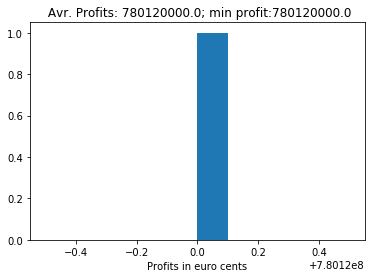

In [ ]:
# real values
Y_targ = df['Eolien'][np.logical_not(df['Eolien'].isna())].values*1000
trading_hours = df['Eolien'][np.logical_not(df['Eolien'].isna())].index

profits = []

# here I set a limit 50000 to our random prediction
Y_pred = 8000*np.ones_like(Y_targ) # constant in kWh scale [0...80000]
profits.append(trader_simulation(trading_hours,Y_pred,Y_targ,debug=True))

plt.hist(profits)
plt.xlabel('Profits in euro cents')
plt.title(f' Avr. Profits: {(np.mean(profits))}; min profit:{(np.min(profits))}');

## Notes on Deployment

In [ ]:
# round to minutes/hours/ etc.:
# pd.to_datetime('now').round('min')
# extract current hour/minute/second/:
# pd.to_datetime('now').second
# ---
# PAUSE EXAMPLE:
# Do sth everyday at 2AM:
# import time
# import datetime

# # if for some reason this script is still running
# # after a year, we'll stop after 365 days
# for i in xrange(0,365):
#     # sleep until 2AM
#     t = datetime.datetime.today()
#     future = datetime.datetime(t.year,t.month,t.day,2,0)
#     if t.hour >= 2:
#         future += datetime.timedelta(days=1)
#     time.sleep((future-t).seconds) # or use total_seconds() if the duration is longer than one day

#     # do 2AM stuff

# CURRENT TIME:
# import time
# import datetime
# t = datetime.datetime.today()
# print('Current time:\n{}/{}/{} {}:{}:{}'.format(t.day,t.month,t.year, t.hour,t.minute,t.second))
# t = datetime.datetime.utcnow()
# print('UTC time:\n{}/{}/{} {}:{}:{}'.format(t.day,t.month,t.year, t.hour,t.minute,t.second))